# European Digital Call Option 
### Vitalii Rudko \ June, 2021

In [3]:
#Importing packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from math import log, exp
from scipy.stats import norm
from numpy.random import normal

ModuleNotFoundError: No module named 'pandas'

## Description
This project aims to describe standard methods of the pricing and the sensitivity analysis of the European digital call option. Digital options are also called binary options or fixed return options. These options are a subtype of exotic options. Binary options can be either European or American style. Besides, they can offer different payoffs. So, if an option pays a fixed coupon after being exercised, then it is a cash-or-nothing option. If the option pays an underlying asset price after being exercised, then it is an asset-or-nothing option. In this project, I am going to consider only cash-or-nothing options. 

Although it is possible to find an authorized trustworthy broker, in most of the cases these options are used on fraudulent trading platforms. In general, the binary option is considered to be a highly risky investment.  

## Payoff Function 
The European cash-or-nothing call is an option paying a fixed coupon $C$ if the spot price $S$ of the underlying asset at maturity $T$ is higher than the predetermined barrier level $K$ [1]. Mathematically its payoff function can expressed as the Heaviside function $\mathcal{H}(x)$:

\begin{equation}
DC_{\mathrm{payoff}} = C \times \mathcal{H}\left(S-K\right),
\end{equation}

where

\begin{equation}
\mathcal{H}(x):=\left\{\begin{array}{ll}
1, & x>0 \\
0, & x\leq0 .
\end{array}\right.
\end{equation}

The examplary payoff function is illustrated below. The stike price is $50$, and the coupon is $20$.  

In [2]:
#Defining functions 

def Heaviside(x):
    if x > 0:
        return 1
    else:
        return 0

def DCpayoff(C, S, K):
    return C * Heaviside(S - K)

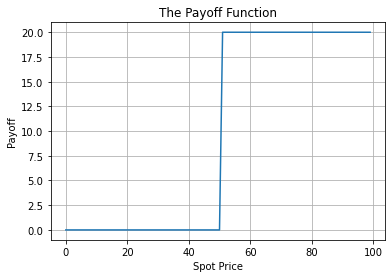

In [3]:
#Calculating payoffs for various spot prices 
payoff_example = [DCpayoff(20, i, 50) for i in range(100)]
payoff_example = np.array(payoff_example)

#Plotting the function
plt.plot(payoff_example)
plt.title("The Payoff Function")
plt.xlabel("Spot Price")
plt.ylabel("Payoff")
plt.grid()

## Pricing 
In this subsection I am going to describe two methods of pricing a binary option, namely analytical Black-Sholes-Merton formula and Monte Carlo simulation. Later on I am going to implement both approaches to an example in Python code, so a reader could compare the results. 

### Analytical Solution
Let us begin with a description of the analytical solution to the problem. The analytical price of the european binary option can be obtained through the framework of a stochastic differential equation derived by Fischer Black and Myron Scholes in 1973 [2]. They used the following set of assumptions: 
* the value of the underlying asset is assumed to be log-normally distributed and follow geometric brownian motion (GBM); 
* the drift parameter $\mu$ and volatility parameter $v$ are constant through time; 
* there are no transaction cost or taxes; 
* dividends are not paid; 
* there is no arbitrage opportunity; 
* the underlying asset can be traded continuously;
* the risk free rate $r$ is constant through the life of the option;

The stochastic differential equation of the option price mentioned above has the following form 

\begin{equation}
\frac{\partial DC}{\partial t}+\frac{1}{2} v^{2} S^{2} \frac{\partial^{2} DC}{\partial S^{2}}+r S \frac{\partial DC}{\partial S}-r DC=0,
\end{equation}

where $DC$ is an option price and $\partial t$ is a small change in time. Another important idea to keep in mind is that we assume the option price to be a function of two variables, namely the asset price and the time, thus $DC(S,t)$.   Now, in order to get a pricing formula we should solve the following final-boundary value problem [3]

\begin{equation}
\left\{\begin{array}{l}
\frac{\partial DC}{\partial t}+\frac{1}{2} v^{2} S^{2} \frac{\partial^{2} DC}{\partial S^{2}}+r S \frac{\partial DC}{\partial S}-r DC=0, \\
DC(0, t)=0 ; DC(S, t) \approx S \text { as } S \rightarrow \infty, \\
DC(S, T)=C \times \mathcal{H}\left(S_{T}-H\right),
\end{array}\right.
\end{equation}

where the second two conditions say, that if the value of the underlying asset is $0$ at any time $t$, then the price of the option is also $0$, similarly, as the asset price increases to the positive infinity the price of the option gets closer to the asset price. The solution to the above problem has the following form 

\begin{equation}
D C(S, t)=C \times \exp(-r(T-t)) \times N\left(d_{2}\right),
\end{equation}

where $N(x)$ is a cumulative distribution function of the standard normal distribution, and 

\begin{equation}
d_{2}=\frac{\log (S / K)+\left(r-\frac{1}{2} v^{2}\right)(T-t)}{v \sqrt{T-t}}.
\end{equation}

### Monte Carlo Simulation
Monte Carlo Simulation is done under the assumption that the asset prices follow GBM and are log-normally distributed the same as in the analytical solution, but here we should use it explicitly in order to be able to simulate the potential trajectories of asset prices, thus it is necessary to define GBM explicitly at this point. 

According to Wikipedia, the geometric brownian motion is a continuous stochastic process, suggested by Black, Sholes and Merton, in which the logarithm of the randomly varying quantity follows a Brownian motion with drift. GBM satisfies the following stochastic differential equation

\begin{equation}
	\partial X_t = \mu X_t \partial t + \sigma X_t \partial w_t
\end{equation}

\begin{equation}
	\frac{\partial X_t}{X_t} = \mu \partial t + \sigma \partial w_t
\end{equation}

where $\mu$ is a mean of log-returns, or the drift parameter, $\sigma$ is a standard deviation of log-returns, or the volatility parameter, $\partial t$ is a small change of time, $\partial w_t = w_t - w_{t-1}$ and $w_t$ is a standard Brownian Motion, therefore $w_t - w_{t-1} \sim \sqrt{\partial t}N(0,1)$. The values of $\partial w_t$ are independent for any short $\partial t$. Integrating both sides using stochastic calculus in the previous equation, we obtain 

\begin{equation}
	X_T = X_{0}\exp{\left(\left(\mu - \frac{\sigma^2}{2}\right)T + \sigma \Delta w_t\right)},
\end{equation} 

where $T$ is time to expiration date. It is important to emphasize that $w_t$ here is eqal to $w_T - w_{0} \sim \sqrt{T}N(0,1)$.

Now, we can use the derived formula to simulate a sufficiently large number of asset prices at the expiration date, and after averaging through obtained prices, we finally obtain an expected asset price at the expiration date. This allows us to calculate the expected discounted payoff of the option, which will be our today's price. 

In [4]:
#Defining functions 

def DC_BSM(S, K, C, r, v, T):
    d2 = (log(S / K) + (r - 0.5 * v**2) * T) / (v * T**0.5)
    return C * exp(-r*T) * norm.cdf(d2)

def GBM(sim, T, mu, v, S0):
    
    output = []
    for i in range(sim):
        output.append(S0 * exp((mu - 0.5 * v**2) * T + v * T**0.5 * normal()))
    
    return output

### Example
As an example let us consider a theoretical option for the S&P500 index with the following characteristics:
1. The option starts on 2021-06-03 and expires in 3 months;
2. The strike price is 4500 points, the coupon is \$50;
3. The risk free rate is a three month treasury bill rate, which is 0.01%; 

The volatility parameter is estimated on the basis of the last three months historical data, which is showed in the figure below.  

In [5]:
#Importing data
sp500_df = yf.download('^GSPC', 
                      start = '2020-03-03', 
                      end = '2021-06-03', 
                      interval = "1d",
                      progress = False)

#Saving quotes in the separate variable
quotes = np.array(sp500_df["Close"])

#Calculating returns
returns = np.diff(np.log(quotes))

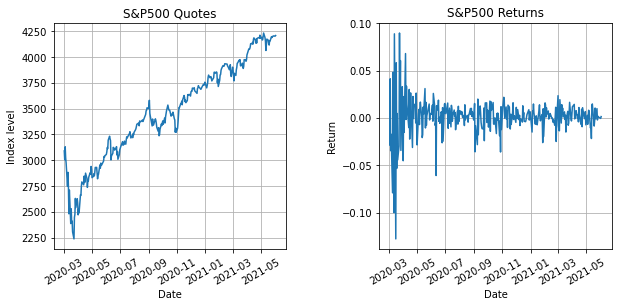

In [6]:
#Plotting S&P500 closing quotes and returns
#Figure parameters 
f1 = plt.figure(figsize=(10,10))
ax1 = f1.add_subplot(221)
ax2 = f1.add_subplot(222)

#Plotting quotes
ax1.plot(sp500_df.index, quotes)
#setting plot parameters;
ax1.set_title("S&P500 Quotes")
ax1.set_xlabel("Date")
ax1.set_ylabel("Index level")
ax1.tick_params(axis = "x", 
                labelrotation = 30)
ax1.grid()

#Plotting returns
ax2.plot(sp500_df.index[1:], returns)
#setting plot parameters;
ax2.set_title("S&P500 Returns")
ax2.set_xlabel("Date")
ax2.set_ylabel("Return")
ax2.tick_params(axis = "x", 
                labelrotation = 30)
ax2.grid()

plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
plt.show()

In [7]:
#S0 - the initial price of underlying asset
S0 = np.array(sp500_df["Close"])[-1]

#K - the barrier
K = 4500

#C - the coupon
C = 50

#r - the risk free rate (3 Month Treasury Bill Rate)
#Source: https://ycharts.com/indicators/3_month_t_bill
r = 0.0001

#T - time to maturity
T = 1/4

#vol - volatility (annual)
v = np.std(returns) * 252**.5

Now, we can calculate the price of the digital call option applying the analytical formula and the estimated volatility parameter.  

In [8]:
#Calculating the price
DC_BSM_price = DC_BSM(S0, K, C, r, v, T)

#Printing the output
output1 = "The option price is $" + str(round(DC_BSM_price, 2)) + "."
print("=" * len(output1))
print(output1)
print("=" * len(output1))

The option price is $15.25.


The same way we can estimate the drift parameter from the data and run 100 000 simulations of future index levels applying GBM model. The figure below represents the first 100 simulations of index levels and their payoffs. 

In [9]:
#mu - mean (annual)
mu = np.mean(returns) * 252

#sim - number of simulations
sim = 100000

In [10]:
#Running simulations 
simulations = GBM(sim, T, mu, v, S0)
payoff_sim = np.array([DCpayoff(C, i, K) for i in simulations])

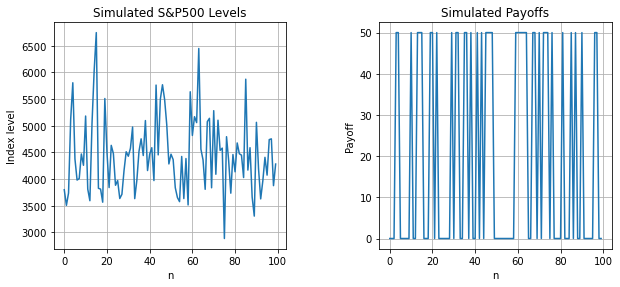

In [11]:
#Plotting simulated values
#Figure parameters 
f2 = plt.figure(figsize=(10,10))
ax1 = f2.add_subplot(221)
ax2 = f2.add_subplot(222)

#Plotting simulated levels
ax1.plot(simulations[0:100])
#setting plot parameters;
ax1.set_title("Simulated S&P500 Levels")
ax1.set_xlabel("n")
ax1.set_ylabel("Index level")
ax1.grid()

#Plotting simulated payoffs
ax2.plot(payoff_sim[0:100])
#setting plot parameters;
ax2.set_title("Simulated Payoffs")
ax2.set_xlabel("n")
ax2.set_ylabel("Payoff")
ax2.grid()

plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
plt.show()

Finally, we can calculate the expected discounted payoff which is actually a price of the option. 

In [12]:
DC_MC_price = np.mean(payoff_sim * exp(-r*T))

#Printing the output
output2 = "The option price is $" + str(round(DC_MC_price, 2)) + "."
print("=" * len(output2))
print(output2)
print("=" * len(output2))

The option price is $22.81.


As we see the analytical solution differs from the simulated one by almost $7, which is a huge difference. The source of the difference is the drift parameter, in the BHM model we assume it to be equal to the risk-free rate, whereas in MC simulations we have a use of the empirical mean log-return of the index levels. 

## Sensitivity Analysis
The sensitivity analysis can be done through the implementation of the so-called greek letters, which are merely partial derivatives of the option price function. Note, earlier it was stated, that the option price function is a function of two variables, but greeks are derived for more than two variables, specifically the volatility and the risk-free rate, so it is assumed, that they do not stay constant in these formulas. 

Here is the list of all basic greek letters and their derived formulas for the digital call option [4] [5]:

1) Delta is a partial derivative of the option price with the respect to the underlying asset price

\begin{align*}
\Delta &= \frac{\partial DC}{\partial S}, \\
       &= \exp(-rT) \times \frac{n(d_2)}{Sv\sqrt{T}}.
\end{align*}

2) Gamma is the second partial derivative of the option price with the respect to the underlying asset price

\begin{align*}
\Gamma &= \frac{\partial^2 DC}{\partial S^2}, \\
       &= -\exp(-rT) \times \frac{d_1n(d_2)}{S^2v^2T}.
\end{align*}

3) Kappa is a partial derivative of the option price with the respect to the volatility parameter

\begin{align*}
K &= \frac{\partial DC}{\partial v}, \\
       &= -\exp(-rT) \times  \frac{d_1n(d_2)}{v}.
\end{align*}

4) Theta is a partial derivative of the option price with the respect to time

\begin{align*}
\Theta &= \frac{\partial DC}{\partial T}, \\
       &= r \exp(-r T) \times N\left(d_{2}\right)+\exp(-r T) \times  n\left(d_{2}\right) \times \left(\frac{d_{1}}{2 T}-\frac{r}{v \sqrt{T}}\right).
\end{align*}

5) Rho is a partial derivative of the option price with the respect to risk-free rate

\begin{align*}
P &= \frac{\partial DC}{\partial r}, \\
       &= -T \exp(-rT) \times (1 - N(d_2)) - \exp(-rT) \frac{\sqrt{T}}{v} \times n(d_2).
\end{align*}

In the obove equations $n(x)$ is the probability density function of the standard normal distribution, and 

\begin{equation}
d_{1}=\frac{\log (S / K)+\left(r+\frac{1}{2} v^{2}\right)T}{v \sqrt{T}}.
\end{equation}  

Note, here we set $t$ to $0$. 

In [13]:
#Defining functions 
def Delta(S, K, r, v, T):
    d2 = (log(S / K) + (r - 0.5 * v**2) * T) / (v * T**0.5)
    return exp(-r * T) * (norm.pdf(d2) / S * v * T ** 0.5)

def Gamma(S, K, r, v, T):
    d1 = (log(S / K) + (r + 0.5 * v**2) * T) / (v * T**0.5)
    d2 = (log(S / K) + (r - 0.5 * v**2) * T) / (v * T**0.5)
    return exp(-r * T) * (d1 * norm.pdf(d2) / S**2 * v**2 * T)

def Kappa(S, K, r, v, T):
    d1 = (log(S / K) + (r + 0.5 * v**2) * T) / (v * T**0.5)
    d2 = (log(S / K) + (r - 0.5 * v**2) * T) / (v * T**0.5)
    return exp(-r * T) * (d1 * norm.pdf(d2) / v)

def Theta(S, K, r, v, T):
    d1 = (log(S / K) + (r + 0.5 * v**2) * T) / (v * T**0.5)
    d2 = (log(S / K) + (r - 0.5 * v**2) * T) / (v * T**0.5)
    return r * exp(-r * T) * norm.cdf(d2) + exp(-r * T) * norm.pdf(d2) * (d1 / (2 * T) - r / (v * T**0.5))

def Rho(S, K, r, v, T):
    d2 = (log(S / K) + (r - 0.5 * v**2) * T) / (v * T**0.5)
    return -T * exp(-r*T) * (1 - norm.cdf(d2)) - exp(-r * T) * T**0.5 / v * norm.pdf(d2)  

### Example 
The estimated greek values for different ranges of independent variables are shown in the plots below. As we see the positive changes in volatility, time and the risk-free rate have a negative impact on the price of the option. Also, low volatility has a huge negative impact on the option price, since it is out of the money at the starting point. The delta function is strictly concave and the gamma function only reflects this. Note, that the figures show a change of the price at a given point for the given constant change of the parameter, not the derivative itself.

In [23]:
#Creating ranges 
S_range = np.arange(4000, 5001, 10)
v_range = np.arange(0.01, 0.51, 0.01)
t_range = np.arange(1/252, T, 1/252)
r_range = np.arange(-0.05, 0.1, 0.001)

In [24]:
#Estimating greeks 
delta = np.array([Delta(i, K, r, v, T) for i in S_range]) * 10
gamma = np.array([Gamma(i, K, r, v, T) for i in S_range]) * 100
kappa = np.array([Kappa(S0, K, r, i, T) for i in v_range]) * 0.01
theta = np.array([Theta(S0, K, r, v, i) for i in t_range]) * 1/252
rho = np.array([Rho(S0, K, i, v, T) for i in r_range]) * 0.001

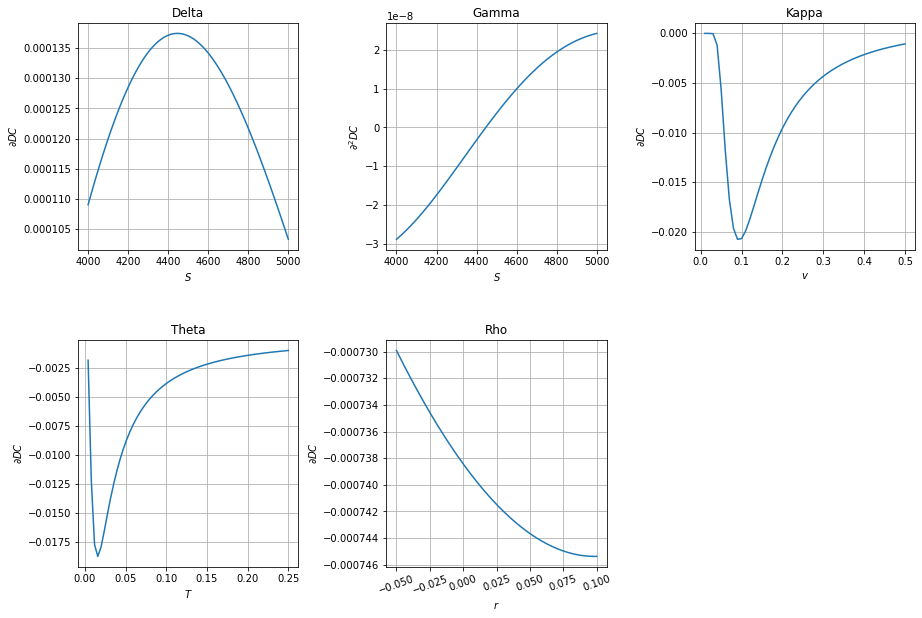

In [27]:
#Plotting simulated greeks
#Figure parameters 
f3 = plt.figure(figsize=(15,10))
ax1 = f3.add_subplot(231)
ax2 = f3.add_subplot(232)
ax3 = f3.add_subplot(233)
ax4 = f3.add_subplot(234)
ax5 = f3.add_subplot(235)

#Plotting simulated levels
ax1.plot(S_range, delta)
#setting plot parameters;
ax1.set_title("Delta")
ax1.set_xlabel("$S$")
ax1.set_ylabel("$\partial DC$")
ax1.grid()

#Plotting simulated levels
ax2.plot(S_range, gamma)
#setting plot parameters;
ax2.set_title("Gamma")
ax2.set_xlabel("$S$")
ax2.set_ylabel("$\partial^2 DC$")
ax2.grid()

#Plotting simulated levels
ax3.plot(v_range, kappa)
#setting plot parameters;
ax3.set_title("Kappa")
ax3.set_xlabel("$v$")
ax3.set_ylabel("$\partial DC$")
ax3.grid()

#Plotting simulated levels
ax4.plot(t_range, theta)
#setting plot parameters;
ax4.set_title("Theta")
ax4.set_xlabel("$T$")
ax4.set_ylabel("$\partial DC$")
ax4.grid()

#Plotting simulated levels
ax5.plot(r_range, rho)
#setting plot parameters;
ax5.set_title("Rho")
ax5.set_xlabel("$r$")
ax5.set_ylabel("$\partial DC$")
ax5.tick_params(axis = "x", 
                labelrotation = 20)
ax5.grid()

plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
plt.show()

## References 
[1] Bouzoubaa, M & Osseiran, A (2010). Exotic Options and Hybrids: A Guide to Structuring, Pricing and Trading. Wiley. 

[2] Black, F & Scholes, M (1973). The Pricing of Options and Corporate Liabilities. Journal of Political Economy.

[3] Lazăr, V (2003). Pricing Digital Call Option in the Heston Stochastic Volatility Model. Studia Universitatis Babeş-Bolyai. Mathematica.

[4] Bartkowiak, M (2021). Lecture materials.

[5] QuantPie. URL: https://quantpie.co.uk/bsm_bin_c_formula/bs_bin_c_summary.php